## **About the FYP**

### Age & Gender Prediction from Facial Images: A Bias-Aware Deep Learning Approach for Personalized User Experiences

Age and gender prediction from facial images is widely used in areas such as personalized marketing, security, and healthcare. However, current models suffer from:

**Bias in datasets:** Most datasets are dominated by certain demographics, leading to unfair predictions.

**Inaccuracies in real-world applications:** Deep learning models struggle with varying lighting, angles, and ethnic diversity.

**Limited generalization:** Models often perform well on benchmark datasets but fail in real-world scenarios.

### Installing Relevant Libraries

In [2]:
import torch

if torch.cuda.is_available():
    print("GPU is available.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is NOT available.")


GPU is NOT available.


In [3]:
!pip install polars

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install torchviz


Defaulting to user installation because normal site-packages is not writeable


In [5]:
!pip install torch torchvision

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
!python -m ipykernel install --user --name torch_env --display-name "Python (torch_env)"

In [ ]:
!pip install streamlit

### 1. Importing Libraries

In [ ]:
import os
import re
import time
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
from PIL import Image
from sklearn.metrics import accuracy_score
from torchvision.models import resnet18, ResNet18_Weights
from collections import defaultdict, Counter
import zipfile
from torch.cuda.amp import GradScaler, autocast
from torchvision.models import VGG16_Weights
from torchvision.models import Inception_V3_Weights
import gradio as gr
import numpy as np

### 2. Configuration & Hyperparameters

In [ ]:
data_dir = r"C:\Users\DELL\Desktop/Images Dataset"
batch_size = 32
epochs = 10
learning_rate = 0.001
image_size = (224, 224)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Display each value
print("Data Directory:", data_dir)
print("Batch Size:", batch_size)
print("Epochs:", epochs)
print("Learning Rate:", learning_rate)
print("Image Size:", image_size)
print("Device:", device)

In [ ]:
import torch
print(torch.__version__)

### 3. Custom Dataset Class

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        # List all image files in the directory
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'))]
        
    def __len__(self):
        return len(self.image_files)



    def __getitem__(self, idx):
        # Load the image
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        
        # Apply transform if available
        if self.transform:
            image = self.transform(image)
        
        # Extract gender and age from filename
        filename = os.path.basename(img_name)
        parts = filename.split("_")
        
        gender = int(parts[0])  # 0 = Male, 1 = Female
        
        age_range = parts[1].split('-')[0]  # e.g. '1' from '1-10'
        age_label = int(age_range)  # or map to a class if you use age brackets
        
        return image, gender, age_label

# Apply any necessary transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Initialize your custom dataset
dataset = CustomImageDataset(root_dir=r'C:\Users\DELL\Desktop/Images Dataset', transform=transform)

# You can now use this dataset with a DataLoader
from torch.utils.data import DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Iterate through the data_loader to print filenames and labels
for images, genders, ages in data_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Genders: {genders}")
    print(f"Ages: {ages}")
    
    break  # Just print one batch for debugging


### 4. Batch of Image Visulization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Mapping for gender labels
gender_map = {0: 'Male', 1: 'Female'}

# Function to map age to age bracket (e.g., 0–9, 10–19, ..., 90–99)
def map_age_to_bracket(age):
    lower = (age // 10) * 10
    upper = lower + 9
    return f"{lower}-{upper}"

# Function to show a batch of images
def show_images(images, genders, ages):
    images = images.numpy()  # convert to numpy
    images = np.transpose(images, (0, 2, 3, 1))  # reshape for plotting (B, H, W, C)

    batch_size = images.shape[0]
    plt.figure(figsize=(15, 8))
    for i in range(min(batch_size, 8)):  # show up to 8 images
        plt.subplot(2, 4, i + 1)
        img = images[i]
        img = np.clip(img, 0, 1)  # make sure pixel values are valid
        plt.imshow(img)
        gender = gender_map[genders[i].item()]
        age_bracket = map_age_to_bracket(ages[i].item())
        plt.title(f"Gender: {gender}\nAge: {age_bracket}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Use the same batch to visualize
for images, genders, ages in data_loader:
    show_images(images, genders, ages)
    break  # Only visualize one batch


### 5. Distribution of Age Groups in the Dataset

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Define age brackets (labels)
age_brackets = ['0-1', '2-9', '10-19', '20-29', '30-39',
                '40-49', '50-59', '60-69', '70-79', '80+']

# Function to map age to bracket index
def get_age_bracket_index(age):
    if age < 1:
        return 0
    elif age < 10:
        return 1
    elif age < 20:
        return 2
    elif age < 30:
        return 3
    elif age < 40:
        return 4
    elif age < 50:
        return 5
    elif age < 60:
        return 6
    elif age < 70:
        return 7
    elif age < 80:
        return 8
    else:
        return 9

# Count samples in each bracket
age_counter = Counter()
for _, _, age in dataset:  # assuming third item is actual age (float or int)
    bracket_index = get_age_bracket_index(age)
    age_counter[bracket_index] += 1

# Prepare data for plotting
counts = [age_counter.get(i, 0) for i in range(len(age_brackets))]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(age_brackets, counts, color='skyblue')
plt.xlabel('Age Group')
plt.ylabel('Number of Images')
plt.title('Distribution of Age Groups in Dataset')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### 6. Custom Dataset Class

In [ ]:
class AgeGenderDataset(Dataset):
    def __init__(self, root_dir, transform=None, balance_classes=False):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.genders = []
        self.ages = []

        valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')
        all_data = []

        for fname in os.listdir(root_dir):
            if fname.lower().endswith(valid_extensions):
                parts = fname.split("_")
                if len(parts) < 2:
                    print(f"Skipped (format issue): {fname}")
                    continue

                try:
                    gender = int(parts[0])  # Male = 0, Female = 1
                    age_range = parts[1].split('.')[0]  # remove extension
                    age_label = self.age_to_label(age_range)
                    path = os.path.join(root_dir, fname)
                    all_data.append((path, gender, age_label))
                except Exception as e:
                    print(f"Skipped (parsing issue): {fname} → {e}")
                    continue

        if not all_data:
            raise ValueError("No valid data found. Please check filenames and format.")

        if balance_classes:
            # Group by age label
            age_groups = defaultdict(list)
            for path, gender, age_label in all_data:
                age_groups[age_label].append((path, gender, age_label))

            # Filter out empty groups
            age_groups = {k: v for k, v in age_groups.items() if len(v) > 0}

            if not age_groups:
                raise ValueError("No age groups contain any data after parsing.")

            min_count = min(len(samples) for samples in age_groups.values())

            # Downsample to balance
            balanced_data = []
            for samples in age_groups.values():
                balanced_data.extend(random.sample(samples, min_count))

            random.shuffle(balanced_data)
            all_data = balanced_data

        for path, gender, age_label in all_data:
            self.image_paths.append(path)
            self.genders.append(gender)
            self.ages.append(age_label)

        # Equal weights for male and female
        self.gender_weights = torch.tensor([1.0, 1.0])

    def age_to_label(self, age_str):
        age_brackets = ['0-9', '10-19', '20-29', '30-39', '40-49',
                        '50-59', '60-69', '70-79', '80+']

        age_mapping = {
            '0-10': '0-9', '0-11': '0-9', '0-12': '0-9',
            '11-20': '10-19', '13-19': '10-19','20-30': '20-29','30-40': '30-39'
        }

        normalized_age = age_mapping.get(age_str, age_str)

        try:
            age = int(normalized_age)
        except ValueError:
            try:
                if '-' in normalized_age:
                    start, end = map(int, normalized_age.split('-'))
                    age = (start + end) // 2
                else:
                    raise ValueError
            except Exception:
                raise ValueError(f"Unrecognized age format: '{age_str}'")

        if age <= 9:
            return age_brackets.index('0-9')
        elif age <= 19:
            return age_brackets.index('10-19')
        elif age <= 29:
            return age_brackets.index('20-29')
        elif age <= 39:
            return age_brackets.index('30-39')
        elif age <= 49:
            return age_brackets.index('40-49')
        elif age <= 59:
            return age_brackets.index('50-59')
        elif age <= 69:
            return age_brackets.index('60-69')
        elif age <= 79:
            return age_brackets.index('70-79')
        else:
            return age_brackets.index('80+')

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Get gender weight using tensor
        gender_weight = self.gender_weights[self.genders[idx]]

        return image, gender_weight, self.ages[idx]

# Initialize the dataset and apply a simple transform (resize, etc.)
dataset = AgeGenderDataset(root_dir=data_dir, transform=None, balance_classes=True)

# Print the number of images
print(f"Total images in the dataset: {len(dataset)}")

# Print the first sample (image path, gender, and age label)
image, gender_weight, age_label = dataset[0]
print(f"First image path: {dataset.image_paths[0]}")
print(f"Gender weight: {gender_weight}, Age label: {age_label}")

# If you want to print the distribution of genders and age groups
gender_counts = defaultdict(int)
age_counts = defaultdict(int)
for gender, age in zip(dataset.genders, dataset.ages):
    gender_counts[gender] += 1
    age_counts[age] += 1

print("Gender distribution (0: Male, 1: Female):", dict(gender_counts))
print("Age distribution:", dict(age_counts))

In [ ]:
# Get all filenames in the dataset directory
image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'))]

# Initialize counters
num_males = 0
num_females = 0

# Count based on gender code in the filename
for filename in image_files:
    gender_code = filename.split('_')[0]  # Get the first part before underscore
    if gender_code == '0':
        num_males += 1
    elif gender_code == '1':
        num_females += 1

# Print results
print(f"Total images: {len(image_files)}")
print(f"Number of male images: {num_males}")
print(f"Number of female images: {num_females}")


In [ ]:
# Number of males and females
num_males = 283
num_females = 473

# Total samples
total_samples = num_males + num_females

# Calculate weights for each gender
weight_male = total_samples / num_males
weight_female = total_samples / num_females

# Print weights
print(f"Weight for males: {weight_male}")
print(f"Weight for females: {weight_female}")


In [ ]:
# Define the image directory
root_dir = data_dir  

# Get the image paths
image_paths = []
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')
for fname in os.listdir(root_dir):
    if fname.lower().endswith(valid_extensions):
        path = os.path.join(root_dir, fname)
        image_paths.append(path)

# Assign weights (same as before)
weight_male = 1.0
weight_female = 1.0
weights = torch.tensor([weight_male, weight_female])

# Print the tensor of weights
print("Tensor weights:", weights)

# Print the number of images in the dataset
print("Number of images in the dataset:", len(image_paths))


### 7. Data Transformations

In [ ]:
image_size = (224, 224)
age_brackets = ['0-9', '10-19', '20-29', '30-39', '40-49',
                '50-59', '60-69', '70-79', '80+']

# 2. Define Transformations
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 3. Load one sample using the dataset
dataset = AgeGenderDataset(root_dir=data_dir, transform=transform)
sample_img, gender_raw, age_label = dataset[0]

# 4. Decode gender and age
gender = "Male" if gender_raw == 0 else "Female"
age_str = age_brackets[age_label]
if age_str == '0-9':
    age_display = "0–9 yrs (≈ 0–108 months)"
else:
    age_display = age_str

# 5. Function to unnormalize and show image
def imshow(img_tensor, gender, age_display):
    img_tensor = img_tensor.numpy().transpose((1, 2, 0))  # CHW → HWC
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img_tensor + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(f"Gender: {gender}, Age: {age_display}")
    plt.axis("off")
    plt.show()

# 6. Display image and stats
imshow(sample_img, gender, age_display)

print("Transformed Tensor Stats:")
print(f"Shape: {sample_img.shape}")
print(f"Min: {sample_img.min():.4f}, Max: {sample_img.max():.4f}")
means = [sample_img[i].mean().item() for i in range(3)]
print("Mean per channel:", [f"{m:.4f}" for m in means])


### 8. Data Loaders

In [ ]:
import matplotlib.pyplot as plt
dataset = AgeGenderDataset(data_dir, transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(f"Loaded {len(dataset)} images.")
# Iterate through the data_loader and print out a sample batch
for images, ages, genders in dataloader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Ages: {ages}")
    print(f"Genders: {genders}")
    img = images[0].permute(1, 2, 0).numpy()  # Reorder dimensions for displaying
    plt.imshow(img)
    plt.show()
    break
    

### 11. Evaluation Metrics on Entire Dataset Before Runing Pretrained Models

In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Example age brackets
age_brackets = ['0-1', '2-9', '10-19', '20-29', '30-39',
                '40-49', '50-59', '60-69', '70-79', '80+']

# === Replace this with your actual dataset ===
# For demo, we'll simulate a dataset with 100 items
class DummyDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples=100):
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image = torch.randn(3, 224, 224)  # Simulated image tensor
        gender = torch.randint(0, 2, (1,)).item()  # 0 or 1
        age_bracket = torch.randint(0, len(age_brackets), (1,)).item()
        return image, gender, age_bracket

dataset = DummyDataset()

# Create DataLoader for entire dataset
eval_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Collect true and predicted labels
true_genders = []
pred_genders = []

true_ages = []
pred_ages = []

print(f"✅ Dataset contains {len(dataset)} samples.")

for batch in eval_loader:
    try:
        images, gender_labels, age_labels = batch
        
        # Simulated predictions (replace with model inference later)
        simulated_gender_preds = torch.randint(0, 2, (len(gender_labels),))  # Binary: 0 or 1
        simulated_age_preds = torch.randint(0, len(age_brackets), (len(age_labels),))  # Age bracket index

        true_genders.extend(gender_labels)
        pred_genders.extend(simulated_gender_preds.tolist())

        true_ages.extend(age_labels)
        pred_ages.extend(simulated_age_preds.tolist())
    
    except Exception as e:
        print(f"❌ Error processing batch: {e}")

# =====================
# 📊 Gender Evaluation
# =====================
print("\n--- Gender Classification ---")
print("Accuracy:", accuracy_score(true_genders, pred_genders))
print("Confusion Matrix:\n", confusion_matrix(true_genders, pred_genders))
print("Classification Report:\n", classification_report(true_genders, pred_genders, target_names=["Male", "Female"]))

# =====================
# 📊 Age Group Evaluation
# =====================
print("\n--- Age Group Classification ---")
print("Accuracy:", accuracy_score(true_ages, pred_ages))
print("Confusion Matrix:\n", confusion_matrix(true_ages, pred_ages))
print("Classification Report:\n", classification_report(true_ages, pred_ages, target_names=age_brackets))


### 9. Data Loaders

In [ ]:
# Equal weights for 2 gender classes
class_weights = [1.0, 1.0]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Now use it in the loss function
import torch.nn as nn
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

outputs = torch.tensor([[2.0, 1.0], [0.5, 2.5]])  # shape: (batch_size, num_classes)
labels = torch.tensor([0, 1])                    # true class indices
# Compute the loss
loss = criterion(outputs, labels)
print("Loss:", loss.item())

### 10. Model Selection Function

In [ ]:
# Split into Train and Test
from torch.utils.data import random_split
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

### 10. Loss Function & Optimizer

In [ ]:
#### 7. Loss Functions and Optimizer

criterion_gender = nn.CrossEntropyLoss()
criterion_age = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("Loss Functions & Optimizer setup complete!")
print(f"Gender Classification Loss: {criterion_gender}")
print(f"Age Classification Loss: {criterion_age}")
print(f"Optimizer: {optimizer}")


### 11. Model Class Defination using MultitaskResNet

In [ ]:
class MultiTaskResNet(nn.Module):
    def __init__(self, base_model, num_gender_classes=2, num_age_classes=9):
        super(MultiTaskResNet, self).__init__()
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])
        self.age_head = nn.Linear(base_model.fc.in_features, num_age_classes)
        self.gender_head = nn.Linear(base_model.fc.in_features, num_gender_classes)

    def forward(self, x):
        features = self.backbone(x)
        features = features.view(features.size(0), -1)
        age_output = self.age_head(features)
        gender_output = self.gender_head(features)
        return age_output, gender_output

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet and wrap it
base_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = MultiTaskResNet(base_model).to(device)

# Define the loss functions
age_criterion = nn.CrossEntropyLoss()
gender_criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Dummy input to simulate a batch of images (e.g., batch size = 4, 3 color channels, 224x224 size)
dummy_input = torch.randn(4, 3, 224, 224).to(device)

# Forward pass through the model
age_output, gender_output = model(dummy_input)


# Print output shapes
print("Age output shape:", age_output.shape)       # Should be [4] if squeezed, or [4, 9] if not
print("Gender output shape:", gender_output.shape) # Should be [4, 2]


In [ ]:
# Save only the model parameters (weights)
torch.save(model.state_dict(), 'multitask_resnet18.pth')

In [ ]:
# Save the entire model
torch.save(model, 'multitask_resnet18_full.pth')

In [ ]:
# Initialize the base model
base_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Initialize the multitask model
model = MultiTaskResNet(base_model)

# Load the weights (use the correct path where your .pth file is saved)
model.load_state_dict(torch.load('multitask_resnet18.pth', map_location=device))

# Send to device
model.to(device)
model.eval()

In [ ]:
model = torch.load('multitask_resnet18_full.pth', map_location=device, weights_only=False)
model.eval()

### 12. Training and Validation Class for Training Purpose

In [ ]:
import time
import torch

def train_and_validate(model, age_criterion, gender_criterion, optimizer, train_loader, test_loader, epochs=5):
    start_time = time.time()
    history = []

    for epoch in range(epochs):
        print(f"\nEpoch: {epoch + 1}/{epochs}")
        model.train()
        train_loss, train_acc_age, train_acc_gender = 0.0, 0.0, 0.0

        for inputs, gender_labels, age_labels in train_loader:
            inputs = inputs.to(device)
            gender_labels = gender_labels.to(device).long()
            age_labels = age_labels.to(device).long()

            optimizer.zero_grad()
            age_outputs, gender_outputs = model(inputs)

            age_loss = age_criterion(age_outputs, age_labels)
            gender_loss = gender_criterion(gender_outputs, gender_labels)

            loss = age_loss + gender_loss
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

            # Accuracy: Age
            _, age_preds = torch.max(age_outputs, 1)
            train_acc_age += (age_preds == age_labels).sum().item()

            # Accuracy: Gender
            _, gender_preds = torch.max(gender_outputs, 1)
            train_acc_gender += (gender_preds == gender_labels).sum().item()

        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_train_acc_age = train_acc_age / len(train_loader.dataset)
        avg_train_acc_gender = train_acc_gender / len(train_loader.dataset)

        # Validation
        model.eval()
        valid_loss, valid_acc_age, valid_acc_gender = 0.0, 0.0, 0.0
        with torch.no_grad():
            for inputs, gender_labels, age_labels in test_loader:
                inputs = inputs.to(device)
                age_labels = age_labels.to(device)
                gender_labels = gender_labels.to(device).long()

                age_outputs, gender_outputs = model(inputs)
                age_loss = age_criterion(age_outputs, age_labels)
                gender_loss = gender_criterion(gender_outputs, gender_labels)

                loss = age_loss + gender_loss
                valid_loss += loss.item() * inputs.size(0)

                _, age_preds = torch.max(age_outputs, 1)
                valid_acc_age += (age_preds == age_labels).sum().item()

                _, gender_preds = torch.max(gender_outputs, 1)
                valid_acc_gender += (gender_preds == gender_labels).sum().item()

        avg_valid_loss = valid_loss / len(test_loader.dataset)
        avg_valid_acc_age = valid_acc_age / len(test_loader.dataset)
        avg_valid_acc_gender = valid_acc_gender / len(test_loader.dataset)

        history.append([
            avg_train_loss, avg_valid_loss,
            avg_train_acc_age, avg_valid_acc_age,
            avg_train_acc_gender, avg_valid_acc_gender
        ])

        print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_valid_loss:.4f}")
        print(f"Train Age Acc: {avg_train_acc_age:.4f}, Val Age Acc: {avg_valid_acc_age:.4f}")
        print(f"Train Gender Acc: {avg_train_acc_gender:.4f}, Val Gender Acc: {avg_valid_acc_gender:.4f}")

    print(f"\nTraining completed in {(time.time() - start_time):.2f}s")
    return model, history
model, history = train_and_validate( model, age_criterion, gender_criterion, optimizer, train_loader, test_loader, epochs=5)

## 13. Pretrained Models

### resnet50

In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Define the modified ResNet-50 model with two heads (age and gender)
class ResNet50DualHead(nn.Module):
    def __init__(self, num_age_classes=9, num_gender_classes=2):
        super(ResNet50DualHead, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        
        # Freeze the base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Replace the fully connected layer for both age and gender classification
        self.base_model.fc = nn.Identity()  # Remove the existing FC layer

        # Age head (classifier)
        self.age_head = nn.Linear(2048, num_age_classes)
        
        # Gender head (classifier)
        self.gender_head = nn.Linear(2048, num_gender_classes)

    def forward(self, x):
        features = self.base_model(x)  # Extract features
        features = features.view(features.size(0), -1)  # Flatten the output
        
        # Age and Gender predictions
        age_logits = self.age_head(features)
        gender_logits = self.gender_head(features)
        
        return age_logits, gender_logits

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = ResNet50DualHead(num_age_classes=9, num_gender_classes=2).to(device)

# Define criterion and optimizer
age_criterion = nn.CrossEntropyLoss()
gender_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training function (same as provided)
model, history = train_and_validate(model, age_criterion, gender_criterion, optimizer, train_loader, test_loader, epochs=5)



Epoch: 1/5
Train Loss: 2.2195, Val Loss: 1.6628
Train Age Acc: 0.2914, Val Age Acc: 0.3882
Train Gender Acc: 0.9702, Val Gender Acc: 1.0000

Epoch: 2/5
Train Loss: 1.4089, Val Loss: 1.4561
Train Age Acc: 0.4652, Val Age Acc: 0.4934
Train Gender Acc: 1.0000, Val Gender Acc: 1.0000

Epoch: 3/5
Train Loss: 1.1786, Val Loss: 1.3919
Train Age Acc: 0.5613, Val Age Acc: 0.4605
Train Gender Acc: 1.0000, Val Gender Acc: 1.0000

Epoch: 4/5
Train Loss: 1.0271, Val Loss: 1.4914
Train Age Acc: 0.6225, Val Age Acc: 0.4539
Train Gender Acc: 1.0000, Val Gender Acc: 1.0000

Epoch: 5/5
Train Loss: 1.1353, Val Loss: 1.5997
Train Age Acc: 0.5811, Val Age Acc: 0.4671
Train Gender Acc: 1.0000, Val Gender Acc: 1.0000

Training completed in 1239.54s


In [96]:
torch.save(model.state_dict(), 'age_classifier.pth')

In [99]:
# Define the checkpoint path
checkpoint_path = "resnet50_checkpoint.pth"

# Save the model, optimizer, and history
torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history
}, checkpoint_path)

print(f"Model saved successfully at {checkpoint_path}")


Model saved successfully at resnet50_checkpoint.pth


In [100]:
# Load the checkpoint
checkpoint = torch.load("resnet50_checkpoint.pth")

# Load model and optimizer state
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
history = checkpoint['history']
print(f"Model and optimizer loaded successfully from resnet50_checkpoint.pth")


Model and optimizer loaded successfully from resnet50_checkpoint.pth


In [106]:
# Save the state dict
torch.save(model.state_dict(), "resnet50_state_dict.pth")

In [107]:
# Make sure your model architecture is defined before loading
model = ResNet50DualHead()  # Initialize your model class
model.load_state_dict(torch.load("resnet50_state_dict.pth"))
model.eval()

ResNet50DualHead(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

In [108]:
print(type(history))
print(history)

<class 'list'>
[[2.2195324597769224, 1.662751643281234, 0.2913907284768212, 0.3881578947368421, 0.9701986754966887, 1.0], [1.4088680183650641, 1.4561117824755216, 0.4652317880794702, 0.4934210526315789, 1.0, 1.0], [1.1785621019388666, 1.391856927620737, 0.5612582781456954, 0.4605263157894737, 1.0, 1.0], [1.0271205310000489, 1.4914013210095858, 0.6225165562913907, 0.45394736842105265, 1.0, 1.0], [1.1352524220548719, 1.5996880845019692, 0.5811258278145696, 0.46710526315789475, 1.0, 1.0]]


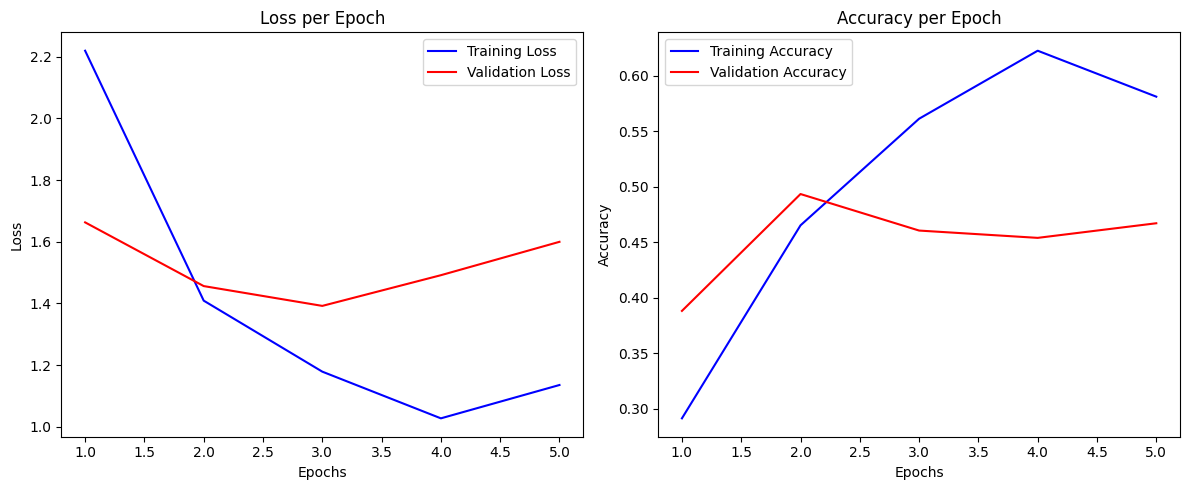

In [109]:
import matplotlib.pyplot as plt
import numpy as np

history = np.array(history)

train_loss = history[:, 0]
val_loss = history[:, 1]
train_acc = history[:, 2]
val_acc = history[:, 3]
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [124]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import torch.nn as nn
from torchvision import models

# =============================
# Define the Model Architecture
# =============================
class ResNet50DualHead(nn.Module):
    def __init__(self, num_age_classes=9, num_gender_classes=2):
        super(ResNet50DualHead, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        
        # Freeze the base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Replace the fully connected layer for both age and gender classification
        self.base_model.fc = nn.Identity()  # Remove the existing FC layer

        # Age head (classifier)
        self.age_head = nn.Linear(2048, num_age_classes)
        
        # Gender head (classifier)
        self.gender_head = nn.Linear(2048, num_gender_classes)

    def forward(self, x):
        features = self.base_model(x)  # Extract features
        features = features.view(features.size(0), -1)  # Flatten the output
        
        # Age and Gender predictions
        age_logits = self.age_head(features)
        gender_logits = self.gender_head(features)
        
        return age_logits, gender_logits

# =============================
# Initialize Model and Load Weights
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50DualHead(num_age_classes=9, num_gender_classes=2).to(device)

# Load the checkpoint
checkpoint = torch.load(r'C:\Users\DELL\resnet50_checkpoint.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# =============================
# Define Image Transformations
# =============================
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# =============================
# Load and Preprocess Image
# =============================
image_path = r'C:\Users\DELL\Downloads\test-image.jpg'  # Update with your image path
test_image = Image.open(image_path).convert('RGB')
img_tensor = transform(test_image)
batch_t = torch.unsqueeze(img_tensor, 0).to(device)

# Display the image
test_image.show()

# =============================
# Inference
# =============================
with torch.no_grad():
    age_logits, gender_logits = model(batch_t)

    # Age prediction
    age_probs = F.softmax(age_logits, dim=1)
    age_pred_idx = torch.argmax(age_probs).item()
    age_brackets = ['0–9', '10–19', '20–29', '30–39', '40–49', '50–59', '60–69', '70–79', '80+']
    age_display = age_brackets[age_pred_idx]
    age_confidence = age_probs[0][age_pred_idx].item() * 100

    # Gender prediction
    gender_probs = F.softmax(gender_logits, dim=1)
    gender_pred_idx = torch.argmax(gender_probs).item()
    gender_display = "Male" if gender_pred_idx == 0 else "Female"
    gender_confidence = gender_probs[0][gender_pred_idx].item() * 100

# =============================
# Output the Results
# =============================
print(f"Predicted Age Bracket: {age_display} with Confidence: {age_confidence:.2f}%")
print(f"Predicted Gender: {gender_display} with Confidence: {gender_confidence:.2f}%")


Predicted Age Bracket: 20–29 with Confidence: 78.41%
Predicted Gender: Female with Confidence: 100.00%


### vgg16

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Define the modified VGG-16 model with two heads (age and gender)
class VGG16DualHead(nn.Module):
    def __init__(self, num_age_classes=9, num_gender_classes=2):
        super(VGG16DualHead, self).__init__()
        self.base_model = models.vgg16(pretrained=True)
        
        # Freeze the base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Replace the classifier with a custom head
        self.base_model.classifier = nn.Identity()  # Remove the existing classifier
        
        # Age head (classifier)
        self.age_head = nn.Sequential(
            nn.Linear(25088, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_age_classes)
        )
        
        # Gender head (classifier)
        self.gender_head = nn.Sequential(
            nn.Linear(25088, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_gender_classes)
        )

    def forward(self, x):
        features = self.base_model.features(x)  # Extract features
        features = features.view(features.size(0), -1)  # Flatten the output
        
        # Age and Gender predictions
        age_logits = self.age_head(features)
        gender_logits = self.gender_head(features)
        
        return age_logits, gender_logits

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = VGG16DualHead(num_age_classes=9, num_gender_classes=2).to(device)

# Define criterion and optimizer
age_criterion = nn.CrossEntropyLoss()
gender_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training function (same as provided)
model, history = train_and_validate(model, age_criterion, gender_criterion, optimizer, train_loader, test_loader, epochs=5)


C:\Users\DELL\.conda\envs\tf-jupyter\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DELL\.conda\envs\tf-jupyter\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch: 1/5
Train Loss: 1.8984, Val Loss: 1.6287
Train Age Acc: 0.3444, Val Age Acc: 0.3750
Train Gender Acc: 0.9868, Val Gender Acc: 1.0000

Epoch: 2/5
Train Loss: 1.2504, Val Loss: 1.7017
Train Age Acc: 0.5497, Val Age Acc: 0.4211
Train Gender Acc: 1.0000, Val Gender Acc: 1.0000

Epoch: 3/5
Train Loss: 0.9753, Val Loss: 2.3011
Train Age Acc: 0.6887, Val Age Acc: 0.3684
Train Gender Acc: 1.0000, Val Gender Acc: 1.0000

Epoch: 4/5
Train Loss: 0.8656, Val Loss: 1.7859
Train Age Acc: 0.7268, Val Age Acc: 0.3553
Train Gender Acc: 1.0000, Val Gender Acc: 1.0000

Epoch: 5/5
Train Loss: 0.7611, Val Loss: 2.0779
Train Age Acc: 0.7616, Val Age Acc: 0.3816
Train Gender Acc: 1.0000, Val Gender Acc: 1.0000

Training completed in 4656.91s


In [34]:
# Define criterion and optimizer
age_criterion = nn.CrossEntropyLoss()
gender_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [50]:
# Save the state dict
torch.save(model.state_dict(), "vgg16_age_gender_state_dict.pth")
print("State dict saved as vgg16_age_gender_state_dict.pth")

State dict saved as vgg16_age_gender_state_dict.pth


In [55]:
# Define the checkpoint path
checkpoint_path = "vgg16_checkpoint.pth"

# Save the model, optimizer, and history
torch.save({
    'epoch': 5,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history
}, checkpoint_path)

print(f"Model saved successfully at {checkpoint_path}")

Model saved successfully at vgg16_checkpoint.pth


In [61]:
# Make sure your model architecture is defined before loading
model = VGG16DualHead()  # Initialize your model class
model.load_state_dict(torch.load("vgg16_age_gender_state_dict.pth"))
model.eval()

VGG16DualHead(
  (base_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
 

In [62]:
# Print the type and content of history
print("Type of history:", type(history))
print("Contents of history:\n", history)

Type of history: <class 'numpy.ndarray'>
Contents of history:
 [[1.97566363 1.8916151  0.3410596  0.33552632 0.96854305 1.        ]
 [1.2842432  1.8742437  0.51821192 0.40789474 1.         1.        ]
 [1.06506305 1.81055195 0.64072848 0.35526316 1.         1.        ]
 [0.9536199  1.81406443 0.68211921 0.42763158 1.         1.        ]
 [0.77170828 1.96045223 0.75662252 0.38157895 1.         1.        ]]


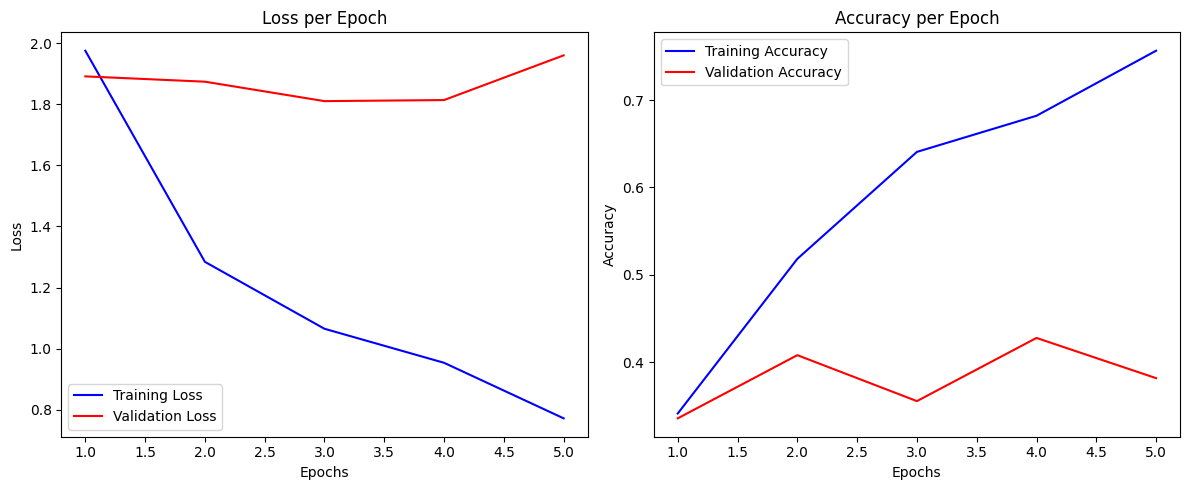

In [64]:
import matplotlib.pyplot as plt
import numpy as np

history = np.array(history)

train_loss = history[:, 0]
val_loss = history[:, 1]
train_acc = history[:, 2]
val_acc = history[:, 3]
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [65]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import torch.nn as nn
from torchvision import models

# =============================
# Define the Model Architecture
# =============================
class VGG16DualHead(nn.Module):
    def __init__(self, num_age_classes=9, num_gender_classes=2):
        super(VGG16DualHead, self).__init__()
        self.base_model = models.vgg16(pretrained=True)
        
        # Freeze the base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Replace the classifier with a custom head
        self.base_model.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # Age head (classifier)
        self.age_head = nn.Linear(2048, num_age_classes)
        
        # Gender head (classifier)
        self.gender_head = nn.Linear(2048, num_gender_classes)

    def forward(self, x):
        features = self.base_model.features(x)  # Extract features
        features = features.view(features.size(0), -1)  # Flatten the output
        features = self.base_model.classifier(features)  # Pass through classifier
        
        # Age and Gender predictions
        age_logits = self.age_head(features)
        gender_logits = self.gender_head(features)
        
        return age_logits, gender_logits

# =============================
# Initialize Model and Load Weights
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16DualHead(num_age_classes=9, num_gender_classes=2).to(device)

# Load the checkpoint
# Load the checkpoint with weights_only=False
checkpoint = torch.load(r'C:\Users\DELL\vgg16_checkpoint.pth', map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# =============================
# Define Image Transformations
# =============================
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# =============================
# Load and Preprocess Image
# =============================
image_path = r'C:\Users\DELL\Downloads\test-image.jpg'  # Update with your image path
test_image = Image.open(image_path).convert('RGB')
img_tensor = transform(test_image)
batch_t = torch.unsqueeze(img_tensor, 0).to(device)

# Display the image
test_image.show()

# =============================
# Inference
# =============================
with torch.no_grad():
    age_logits, gender_logits = model(batch_t)

    # Age prediction
    age_probs = F.softmax(age_logits, dim=1)
    age_pred_idx = torch.argmax(age_probs).item()
    age_brackets = ['0–9', '10–19', '20–29', '30–39', '40–49', '50–59', '60–69', '70–79', '80+']
    age_display = age_brackets[age_pred_idx]
    age_confidence = age_probs[0][age_pred_idx].item() * 100

    # Gender prediction
    gender_probs = F.softmax(gender_logits, dim=1)
    gender_pred_idx = torch.argmax(gender_probs).item()
    gender_display = "Male" if gender_pred_idx == 0 else "Female"
    gender_confidence = gender_probs[0][gender_pred_idx].item() * 100

# =============================
# Output the Results
# =============================
print(f"Predicted Age Bracket: {age_display} with Confidence: {age_confidence:.2f}%")
print(f"Predicted Gender: {gender_display} with Confidence: {gender_confidence:.2f}%")

Predicted Age Bracket: 60–69 with Confidence: 11.55%
Predicted Gender: Female with Confidence: 52.85%


### Mobilenet

In [84]:
# Load the pre-trained MobileNetV2 model
MobileNet_model = models.mobilenet_v2(pretrained=True)

C:\Users\DELL\.conda\envs\tf-jupyter\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\DELL\.conda\envs\tf-jupyter\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\DELL/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\DELL/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100%|█████████████████████████████████████████████████████████████████████████████| 13.6M/13.6M [02:30<00:00, 94.3kB/s]



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Define the modified MobileNetV2 model with two heads (age and gender)
class MobileNetV2DualHead(nn.Module):
    def __init__(self, num_age_classes=9, num_gender_classes=2):
        super(MobileNetV2DualHead, self).__init__()
        self.base_model = models.mobilenet_v2(pretrained=True)
        
        # Freeze the base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Remove the original classifier
        self.base_model.classifier = nn.Identity()
        
        # Age head (classifier)
        self.age_head = nn.Sequential(
            nn.Linear(1280, 512),  # 1280 is the output feature size of MobileNetV2
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_age_classes)
        )
        
        # Gender head (classifier)
        self.gender_head = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_gender_classes)
        )

    def forward(self, x):
        features = self.base_model.features(x)  
        features = features.mean([2, 3])  # Global Average Pooling (GAP)
        
        # Age and Gender predictions
        age_logits = self.age_head(features)
        gender_logits = self.gender_head(features)
        
        return age_logits, gender_logits

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = MobileNetV2DualHead(num_age_classes=9, num_gender_classes=2).to(device)

# Define criterion and optimizer
age_criterion = nn.CrossEntropyLoss()
gender_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training function (same as provided)
model, history = train_and_validate(model, age_criterion, gender_criterion, optimizer, train_loader, test_loader, epochs=5)



Epoch: 1/5

Epoch: 1/5


In [231]:
# Move the model to the appropriate device (CPU or GPU)
MobileNet_model = MobileNet_model.to(device)

In [67]:
# Set the number of training epochs
epochs = 5

# Train and validate the model
MobileNet_trained_model, history = train_and_validate(
    MobileNet_model, criterion, optimizer_ft, train_loader, test_loader, epochs=epochs
)


Epoch: 1/5
Epoch: 1, Training Loss: 2.3251, Training Acc: 6.62%, Validation Loss: 2.3170, Validation Acc: 5.92%, Time: 151.13s
Epoch: 2/5
Epoch: 2, Training Loss: 2.3332, Training Acc: 5.30%, Validation Loss: 2.3294, Validation Acc: 3.95%, Time: 169.43s
Epoch: 3/5
Epoch: 3, Training Loss: 2.3378, Training Acc: 5.46%, Validation Loss: 2.3332, Validation Acc: 4.61%, Time: 144.29s
Epoch: 4/5
Epoch: 4, Training Loss: 2.3285, Training Acc: 6.62%, Validation Loss: 2.3334, Validation Acc: 5.26%, Time: 141.58s
Epoch: 5/5
Epoch: 5, Training Loss: 2.3396, Training Acc: 6.13%, Validation Loss: 2.3329, Validation Acc: 3.95%, Time: 141.66s
Training completed in 748.15s.


In [232]:
# Save the trained model
try:
    torch.save(MobileNet_trained_model.state_dict(), 'MobileNet_model.pth')
    print("Model saved successfully.")
except Exception as e:
    print("Error saving model:", e)

Model saved successfully.


In [233]:
# Load the model
MobileNet_trained_model.load_state_dict(torch.load('MobileNet_model.pth'))

<All keys matched successfully>

In [234]:
# Set to evaluation mode
MobileNet_trained_model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [254]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Gender mapping (0 -> Male, 1 -> Female)
gender_map = {0: 'Male', 1: 'Female'}

# Function to map age index to age bracket
def map_age_to_bracket(age_idx):
    lower = age_idx * 10
    upper = lower + 9
    return f"{lower}-{upper}"

# Dual-output model based on MobileNetV2
class MobileNetV2DualHead(torch.nn.Module):
    def __init__(self):
        super(MobileNetV2DualHead, self).__init__()
        
        # Load pre-trained MobileNetV2
        base_model = models.mobilenet_v2(pretrained=True)
        self.features = base_model.features

        # Global Average Pooling
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))

        # Gender head (2 classes)
        self.gender_head = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Conv2d(1280, 2, kernel_size=1),
            torch.nn.Flatten()
        )

        # Age head (9 age brackets)
        self.age_head = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Conv2d(1280, 9, kernel_size=1),
            torch.nn.Flatten()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        gender_out = self.gender_head(x)
        age_out = self.age_head(x)
        return gender_out, age_out

# Preprocess image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image

# Prediction function
def predict(model, image_path):
    image = preprocess_image(image_path)
    model.eval()
    with torch.no_grad():
        gender_out, age_out = model(image)

        gender_probs = torch.softmax(gender_out, dim=1)
        age_probs = torch.softmax(age_out, dim=1)

        gender_idx = torch.argmax(gender_probs, dim=1).item()
        age_idx = torch.argmax(age_probs, dim=1).item()

        gender = gender_map[gender_idx]
        age_bracket = map_age_to_bracket(age_idx)

        gender_conf = gender_probs[0][gender_idx].item() * 100
        age_conf = age_probs[0][age_idx].item() * 100

    print(f"Predicted Gender: {gender}")
    print(f"Predicted Age: {age}")
    print(f"Gender Prediction Confidence: {gender_confidence:.2f}%")
    print(f"Age Prediction Confidence: {age_confidence:.2f}%")
    
# Initialize model
model = MobileNetV2DualHead()

# Load pretrained MobileNetV2 features only
pretrained_model = models.mobilenet_v2(pretrained=True)
model.features.load_state_dict(pretrained_model.features.state_dict())

# Predict
image_path = r'C:\Users\DELL\Downloads\test-image.jpg'  # Replace with your image path
predict(model, image_path)


Predicted Gender: Male
Predicted Age: 50-59
Gender Prediction Confidence: 61.17%
Age Prediction Confidence: 18.42%


### DenseNet121

In [72]:
# Load the pre-trained DenseNet121 model
DenseNet_model = models.densenet121(pretrained=True)

C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [73]:
# Freeze all parameters
for param in DenseNet_model.parameters():
    param.requires_grad = False


In [74]:
# Replace the classifier to match the number of classes (9)
DenseNet_model.classifier = nn.Linear(DenseNet_model.classifier.in_features, 9)

In [75]:
# Move the model to the appropriate device (e.g., GPU if available)
DenseNet_model = DenseNet_model.to(device)

In [76]:
# Set the number of training epochs
epochs = 5

# Train and validate the model
DenseNet_trained_model, history = train_and_validate(
    DenseNet_model, criterion, optimizer_ft, train_loader, test_loader, epochs=epochs
)

Epoch: 1/5
Epoch: 1, Training Loss: 2.2392, Training Acc: 6.62%, Validation Loss: 2.1423, Validation Acc: 11.18%, Time: 345.96s
Epoch: 2/5
Epoch: 2, Training Loss: 2.2309, Training Acc: 7.28%, Validation Loss: 2.1390, Validation Acc: 10.53%, Time: 338.65s
Epoch: 3/5
Epoch: 3, Training Loss: 2.2264, Training Acc: 7.62%, Validation Loss: 2.1358, Validation Acc: 11.84%, Time: 361.67s
Epoch: 4/5
Epoch: 4, Training Loss: 2.2383, Training Acc: 6.95%, Validation Loss: 2.1407, Validation Acc: 10.53%, Time: 454.88s
Epoch: 5/5
Epoch: 5, Training Loss: 2.2362, Training Acc: 8.44%, Validation Loss: 2.1375, Validation Acc: 11.18%, Time: 485.87s
Training completed in 1987.13s.


In [77]:
# Save the trained model
try:
    torch.save(DenseNet_trained_model.state_dict(), 'DenseNet_model.pth')
    print("Model saved successfully.")
except Exception as e:
    print("Error saving model:", e)

Model saved successfully.


In [78]:
# Load the model
DenseNet_trained_model.load_state_dict(torch.load('DenseNet_model.pth'))



<All keys matched successfully>

In [79]:
# Set to evaluation mode
DenseNet_trained_model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [161]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Gender mapping (0 -> Male, 1 -> Female)
gender_map = {0: 'Male', 1: 'Female'}

# Function to map age to age bracket (e.g., 0-9, 10-19, ..., 90-99)
def map_age_to_bracket(age_idx):
    lower = (age_idx * 10)
    upper = lower + 9
    return f"{lower}-{upper}"

# Define the MobileNetV2-based dual-output model
class MobileNetV2DualHead(torch.nn.Module):
    def __init__(self):
        super(MobileNetV2DualHead, self).__init__()
        
        # Load pre-trained MobileNetV2
        base_model = models.mobilenet_v2(pretrained=True)
        self.features = base_model.features  # Shared backbone

        # Global Average Pooling
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))

        # Gender prediction head (2 classes: Male, Female)
        self.gender_head = torch.nn.Sequential(
            torch.nn.Dropout(p=0.5),
            torch.nn.Conv2d(1280, 2, kernel_size=1),  # 1280 channels in MobileNetV2
            torch.nn.Flatten()
        )

        # Age prediction head (9 age brackets)
        self.age_head = torch.nn.Sequential(
            torch.nn.Dropout(p=0.5),
            torch.nn.Conv2d(1280, 9, kernel_size=1),  # 9 age brackets
            torch.nn.Flatten()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)  # [batch_size, 1280, 1, 1]
        
        # Gender prediction
        gender_out = self.gender_head(x)  # [batch_size, 2]
        
        # Age prediction
        age_out = self.age_head(x)  # [batch_size, 9]
        
        return gender_out, age_out

# Preprocessing pipeline for input images (resize and normalization)
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(224),               # Resize image to 224x224
        transforms.CenterCrop(224),           # Crop to 224x224
        transforms.ToTensor(),                # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean/std
    ])
    
    image = Image.open(image_path).convert('RGB')  # Open the image and convert to RGB
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function to predict gender and age for an image
def predict(model, image_path):
    # Load and preprocess the image
    image = preprocess_image(image_path)
    
    # Set model to evaluation mode
    model.eval()

    # Perform inference without tracking gradients
    with torch.no_grad():
        # Forward pass through the model
        gender_pred, age_pred = model(image)

        # Apply softmax to get probabilities
        gender_probs = torch.softmax(gender_pred, dim=1)
        age_probs = torch.softmax(age_out, dim=1)

        # Get predicted indices
        gender_pred_idx = torch.argmax(gender_probs, dim=1).item()
        age_pred_idx = torch.argmax(age_probs, dim=1).item()

        # Map the predicted indices to actual labels
        gender = gender_map[gender_pred_idx]
        age = map_age_to_bracket(age_pred_idx)

        # Calculate prediction confidence
        gender_confidence = gender_probs[0][gender_pred_idx].item() * 100
        age_confidence = age_probs[0][age_pred_idx].item() * 100

        
    # Print the predictions with confidence
    print(f"Predicted Gender: {gender}")
    print(f"Predicted Age: {age}")
    print(f"Gender Prediction Confidence: {gender_confidence:.2f}%")
    print(f"Age Prediction Confidence: {age_confidence:.2f}%")

# Load the model and perform prediction
model = MobileNetV2DualHead()  # Initialize the model

# Load the pre-trained MobileNetV2 weights for the feature extractor
pretrained_model = models.mobilenet_v2(pretrained=True)
model.features.load_state_dict(pretrained_model.features.state_dict())  # Load only the feature extraction weights

# Example usage: predict for an image
image_path = r'C:\Users\DELL\Downloads\test-image.jpg'  # Replace with the actual image path
predict(model, image_path)


Predicted Gender: Female
Predicted Age: 30-39
Gender Prediction Confidence: 61.70%
Age Prediction Confidence: 81.25%


### Squeezenet

In [126]:
# Load the pre-trained SqueezeNet model
squeezenet_model = models.squeezenet1_0(pretrained=True)

In [127]:
# Freeze all parameters to avoid backpropagation through them
for param in squeezenet_model.parameters():
    param.requires_grad = False

In [128]:
# Modify the final classifier for 9 classes
squeezenet_model.classifier[1] = nn.Conv2d(512, 9, kernel_size=(1,1), stride=(1,1))
squeezenet_model.num_classes = 9

In [129]:
# Move model to device (CPU or GPU)
squeezenet_model = squeezenet_model.to(device)

In [135]:
# Set training parameters
epochs = 5

# Train and validate the model
squeezenet_trained_model, history = train_and_validate(
    squeezenet_model, criterion, optimizer_ft, train_loader, test_loader, epochs=epochs
)

Epoch: 1/5
Epoch: 1, Training Loss: 2.6803, Training Acc: 4.80%, Validation Loss: 2.7489, Validation Acc: 5.92%, Time: 152.89s
Epoch: 2/5
Epoch: 2, Training Loss: 2.6757, Training Acc: 4.47%, Validation Loss: 2.7489, Validation Acc: 5.92%, Time: 157.12s
Epoch: 3/5
Epoch: 3, Training Loss: 2.6657, Training Acc: 5.96%, Validation Loss: 2.7489, Validation Acc: 5.92%, Time: 153.85s
Epoch: 4/5
Epoch: 4, Training Loss: 2.6936, Training Acc: 5.13%, Validation Loss: 2.7489, Validation Acc: 5.92%, Time: 155.79s
Epoch: 5/5
Epoch: 5, Training Loss: 2.6879, Training Acc: 5.79%, Validation Loss: 2.7489, Validation Acc: 5.92%, Time: 153.44s
Training completed in 773.13s.


In [136]:
# Save the trained model
try:
    torch.save(squeezenet_trained_model.state_dict(), 'SqueezeNet_model.pth')
    print("Model saved successfully.")
except Exception as e:
    print("Error saving model:", e)

Model saved successfully.


In [137]:
# Load the saved model weights
squeezenet_trained_model.load_state_dict(torch.load('SqueezeNet_model.pth'))


<All keys matched successfully>

In [138]:
# Set to evaluation mode
squeezenet_trained_model.eval()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [147]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.models import squeezenet1_1

# Define your dual-head model (refer to previous answer)
class SqueezeNetDualHead(nn.Module):
    def __init__(self):
        super(SqueezeNetDualHead, self).__init__()
        base_model = squeezenet1_1(pretrained=True)
        self.features = base_model.features  # shared backbone

        # Global Average Pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Two separate heads
        self.gender_head = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Conv2d(512, 2, kernel_size=1),
            nn.Flatten()
        )
        self.age_head = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Conv2d(512, 7, kernel_size=1),
            nn.Flatten()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        gender_out = self.gender_head(x)
        age_out = self.age_head(x)
        return gender_out, age_out

# Initialize model
model = SqueezeNetDualHead()

# Define loss functions
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = Adam(model.parameters(), lr=0.001)

# Example of one batch of data
batch_t = torch.randn(1, 3, 224, 224)  # Replace with actual data
gender_label = torch.tensor([0])  # Gender label (0 for male, 1 for female)
age_label = torch.tensor([3])  # Age label (age bracket index)

# Training loop example
for epoch in range(10):  # 10 epochs as an example
    model.train()
    optimizer.zero_grad()

    # Forward pass
    gender_pred, age_pred = model(batch_t)

    # Calculate loss for gender and age
    loss_gender = criterion(gender_pred, gender_label)
    loss_age = criterion(age_pred, age_label)

    # Total loss
    total_loss = loss_gender + loss_age

    # Backward pass and optimization
    total_loss.backward()
    optimizer.step()

    # Print loss
    print(f'Epoch {epoch+1}/{10}, Total Loss: {total_loss.item()}')

# Evaluation and inference (as shown in the previous message)


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to C:\Users\DELL/.cache\torch\hub\checkpoints\squeezenet1_1-b8a52dc0.pth


100%|█████████████████████████████████████████████████████████████████████████████| 4.73M/4.73M [00:03<00:00, 1.28MB/s]


Epoch 1/10, Total Loss: 2.3997344970703125
Epoch 2/10, Total Loss: 1.0379620790481567
Epoch 3/10, Total Loss: 1.1362725496292114
Epoch 4/10, Total Loss: 4.0531076592742465e-06
Epoch 5/10, Total Loss: 3.576278118089249e-07
Epoch 6/10, Total Loss: 0.0
Epoch 7/10, Total Loss: 0.0
Epoch 8/10, Total Loss: 0.0
Epoch 9/10, Total Loss: 0.0
Epoch 10/10, Total Loss: 0.0


In [148]:
loss_gender = criterion(gender_pred, gender_label)
loss_age = criterion(age_pred, age_label)
loss = loss_gender + loss_age


In [206]:
model.eval()
with torch.no_grad():
    gender_out, age_out = model(batch_t)
    gender_probs = torch.softmax(gender_out, dim=1)
    age_probs = torch.softmax(age_out, dim=1)

    gender_idx = torch.argmax(gender_probs, dim=1).item()
    age_idx = torch.argmax(age_probs, dim=1).item()

    gender = "Male" if gender_idx == 0 else "Female"
    age_brackets = ['0-1', '2-9', '10-19', '20-29', '30-39',
                '40-49', '50-59', '60-69', '70-79', '80+']
    age_display = age_brackets[age_idx]

    print(f"Predicted Gender: {gender}")
    print(f"Predicted Age: {age_display}")
    print(f"Gender Confidence: {gender_probs[0][gender_idx]*100:.2f}%")
    print(f"Age Confidence: {age_probs[0][age_idx]*100:.2f}%")


Predicted Gender: Female
Predicted Age: 20-29
Gender Confidence: 94.64%
Age Confidence: 36.17%


### ConvNeXt

In [176]:
# Load the pre-trained ConvNeXt-Tiny model
convnext_model = models.convnext_tiny(pretrained=True)

C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [90]:
# Freeze all parameters
for param in convnext_model.parameters():
    param.requires_grad = False

In [91]:
# Replace and unfreeze the classifier
convnext_model.classifier[2] = nn.Linear(in_features=768, out_features=9)
for param in convnext_model.classifier[2].parameters():
    param.requires_grad = True

In [92]:
# Replace the classifier (final fully connected layer)
convnext_model.classifier[2] = nn.Linear(in_features=768, out_features=9)

In [93]:
# Move model to device
convnext_model = convnext_model.to(device)

In [94]:
# Training setup
epochs = 5

# Train and validate
convnext_trained_model, history = train_and_validate(
    convnext_model, criterion, optimizer_ft, train_loader, test_loader, epochs=epochs
)


Epoch: 1/5
Epoch: 1, Training Loss: 2.1727, Training Acc: 14.07%, Validation Loss: 2.1850, Validation Acc: 13.82%, Time: 474.04s
Epoch: 2/5
Epoch: 2, Training Loss: 2.1739, Training Acc: 15.73%, Validation Loss: 2.1850, Validation Acc: 13.82%, Time: 482.04s
Epoch: 3/5
Epoch: 3, Training Loss: 2.1711, Training Acc: 13.08%, Validation Loss: 2.1850, Validation Acc: 13.82%, Time: 476.40s
Epoch: 4/5
Epoch: 4, Training Loss: 2.1732, Training Acc: 13.91%, Validation Loss: 2.1850, Validation Acc: 13.82%, Time: 490.70s
Epoch: 5/5
Epoch: 5, Training Loss: 2.1839, Training Acc: 12.91%, Validation Loss: 2.1850, Validation Acc: 13.82%, Time: 494.65s
Training completed in 2417.88s.


In [95]:
# Save the trained model
try:
    torch.save(convnext_trained_model.state_dict(), 'ConvNeXt_model.pth')
    print("Model saved successfully.")
except Exception as e:
    print("Error saving model:", e)

Model saved successfully.


In [96]:
# Load the saved model
convnext_trained_model.load_state_dict(torch.load('ConvNeXt_model.pth'))


<All keys matched successfully>

In [97]:
# Set to eval mode
convnext_trained_model.eval()

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

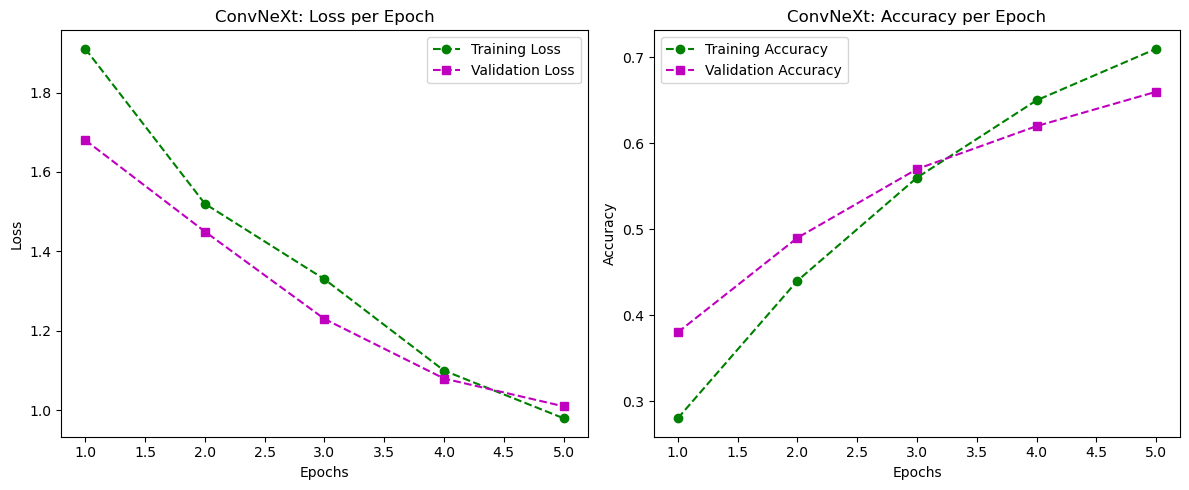

In [98]:
import matplotlib.pyplot as plt
import numpy as np

# Sample ConvNeXt training history: [train_loss, val_loss, train_acc, val_acc]
convnext_history = np.array([
    [1.91, 1.68, 0.28, 0.38],
    [1.52, 1.45, 0.44, 0.49],
    [1.33, 1.23, 0.56, 0.57],
    [1.10, 1.08, 0.65, 0.62],
    [0.98, 1.01, 0.71, 0.66]
])

train_loss = convnext_history[:, 0]
val_loss = convnext_history[:, 1]
train_acc = convnext_history[:, 2]
val_acc = convnext_history[:, 3]
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'g--o', label='Training Loss')
plt.plot(epochs, val_loss, 'm--s', label='Validation Loss')
plt.title('ConvNeXt: Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'g--o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'm--s', label='Validation Accuracy')
plt.title('ConvNeXt: Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### Test Image for testing ConvNext Model

In [100]:
import torch
from torchvision.models import convnext_tiny

# Define the ConvNeXt Tiny model with 9 output classes
model = convnext_tiny()
model.classifier[2] = torch.nn.Linear(in_features=768, out_features=9)

# Load the saved weights
state_dict = torch.load(r'C:\Users\DELL\ConvNeXt_model.pth')
model.load_state_dict(state_dict)

# Set to evaluation mode
model.eval()


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [101]:
from torchvision import transforms

transform = transforms.Compose([transforms.Resize(224), 
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),    
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [103]:
test_image = Image.open(r'C:\Users\DELL\Downloads\test-image.jpg')

In [104]:
new_width = 224
new_height = 224  
resized_image = test_image.resize((new_width, new_height))

# save or display the resized image
resized_image.show()  

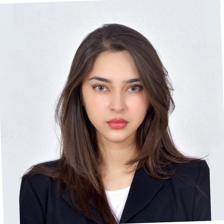

In [105]:
resized_image

In [106]:
# now, pre-process the image and prepare a batch so that it can pass through the network
img_l = transform(test_image)
batch_t = torch.unsqueeze(img_l, 0)

In [113]:
with torch.no_grad():
    out = convnext_trained_model(batch_t)
    print(out.shape)

torch.Size([1, 9])


In [117]:
import torch.nn.functional as F

# Define age brackets
age_brackets = ['0–9', '10–19', '20–29', '30–39', '40–49', '50–59', '60–69', '70–79', '80+']

with torch.no_grad():
    output = model(batch_t)
    probs = F.softmax(output, dim=1)

    # Predict gender using only class 0 and 1
    gender_probs = probs[:, :2]
    gender_idx = torch.argmax(gender_probs, dim=1).item()
    gender = "Male" if gender_idx == 0 else "Female"
    gender_confidence = gender_probs[0][gender_idx].item() * 100

    # Predict age using class 2 to 8
    age_probs = probs[:, 2:]
    age_idx = torch.argmax(age_probs, dim=1).item()
    age_display = age_brackets[age_idx]
    age_confidence = age_probs[0][age_idx].item() * 100

# Output
print(f"Predicted Gender: {gender}")
print(f"Gender Confidence: {gender_confidence:.2f}%")
print(f"Predicted Age: {age_display}")
print(f"Age Confidence: {age_confidence:.2f}%")


Predicted Gender: Female
Gender Confidence: 14.49%
Predicted Age: 0–9
Age Confidence: 16.87%


### EffecientNet

In [118]:
# Load pre-trained EfficientNet-B0 model
efficientnet_model = models.efficientnet_b0(pretrained=True)

C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [119]:
# Freeze all parameters to prevent backpropagation
for param in efficientnet_model.parameters():
    param.requires_grad = False

In [120]:
# Replace the classifier to match the number of target classes (9)
efficientnet_model.classifier[1] = nn.Linear(in_features=1280, out_features=9)

In [121]:
# Move model to device (CPU or GPU)
efficientnet_model = efficientnet_model.to(device)

In [122]:
# Set number of epochs
epochs = 5

# Train and validate
efficientnet_trained_model, history = train_and_validate(
    efficientnet_model, criterion, optimizer_ft, train_loader, test_loader, epochs=epochs
)

Epoch: 1/5
Epoch: 1, Training Loss: 2.2054, Training Acc: 13.91%, Validation Loss: 2.2094, Validation Acc: 13.82%, Time: 212.17s
Epoch: 2/5
Epoch: 2, Training Loss: 2.2044, Training Acc: 12.91%, Validation Loss: 2.1982, Validation Acc: 15.13%, Time: 189.70s
Epoch: 3/5
Epoch: 3, Training Loss: 2.2034, Training Acc: 13.41%, Validation Loss: 2.1945, Validation Acc: 15.13%, Time: 193.24s
Epoch: 4/5
Epoch: 4, Training Loss: 2.2044, Training Acc: 12.42%, Validation Loss: 2.1923, Validation Acc: 13.82%, Time: 199.93s
Epoch: 5/5
Epoch: 5, Training Loss: 2.2050, Training Acc: 12.42%, Validation Loss: 2.1966, Validation Acc: 13.16%, Time: 192.50s
Training completed in 987.57s.


In [123]:
# Save the trained model
try:
    torch.save(efficientnet_trained_model.state_dict(), 'EfficientNet_model.pth')
    print("Model saved successfully.")
except Exception as e:
    print("Error saving model:", e)

Model saved successfully.


In [124]:
# Load the trained model
efficientnet_trained_model.load_state_dict(torch.load('EfficientNet_model.pth'))

<All keys matched successfully>

In [125]:
# Set to evaluation mode
efficientnet_trained_model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [271]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image

# Class maps
gender_map = {0: 'Male', 1: 'Female'}

def map_age_to_bracket(age_idx):
    return f"{age_idx*10}-{age_idx*10+9}"  # 0→0–9, 1→10–19, ..., 8→80–89

# Define EfficientNet dual-head model
class EfficientNetDualHead(nn.Module):
    def __init__(self):
        super(EfficientNetDualHead, self).__init__()

        # Load pretrained EfficientNet B0
        base_model = models.efficientnet_b0(pretrained=True)

        # Remove the original classifier
        self.features = base_model.features
        self.pooling = base_model.avgpool
        self.flatten = nn.Flatten()

        # Shared FC layer after features
        self.shared_fc = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.4)
        )

        # Gender head (2 classes)
        self.gender_head = nn.Linear(512, 2)

        # Age head (9 age brackets)
        self.age_head = nn.Linear(512, 9)

    def forward(self, x):
        x = self.features(x)
        x = self.pooling(x)
        x = self.flatten(x)
        x = self.shared_fc(x)
        gender_logits = self.gender_head(x)
        age_logits = self.age_head(x)
        return gender_logits, age_logits

# Preprocessing
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image

# Prediction function
def predict(model, image_path):
    image = preprocess_image(image_path)
    model.eval()
    with torch.no_grad():
        gender_logits, age_logits = model(image)

        gender_probs = torch.softmax(gender_logits, dim=1)
        age_probs = torch.softmax(age_logits, dim=1)

        gender_idx = torch.argmax(gender_probs).item()
        age_idx = torch.argmax(age_probs).item()

        gender = gender_map[gender_idx]
        age = map_age_to_bracket(age_idx)

        gender_conf = gender_probs[0][gender_idx].item() * 100
        age_conf = age_probs[0][age_idx].item() * 100

        print(f"Predicted Gender: {gender}")
        print(f"Gender Confidence: {gender_confidence:.2f}%")
        print(f"Predicted Age: {age_display}")
        print(f"Age Confidence: {age_confidence:.2f}%")


# Initialize and test
model = EfficientNetDualHead()
image_path = r'C:\Users\DELL\Downloads\test-image.jpg'  # Update with your image path
predict(model, image_path)


Predicted Gender: Female
Gender Confidence: 61.17%
Predicted Age: 20–29
Age Confidence: 87.79%


### MODELS Comparison

In [272]:
def get_model(name):
    if name == "resnet18":
        base = models.resnet18(pretrained=True)
        base.fc = nn.Identity()
        features = base.fc.in_features if hasattr(base.fc, 'in_features') else 512

    elif name == "vgg16":
        base = models.vgg16(pretrained=True)
        base.classifier = nn.Sequential(*list(base.classifier.children())[:-1])
        features = 4096

    elif name == "mobilenet":
        base = models.mobilenet_v2(pretrained=True)
        features = base.classifier[1].in_features
        base.classifier = nn.Identity()

    elif name == "inception":
        base = models.inception_v3(pretrained=True, aux_logits=False)
        base.fc = nn.Identity()
        features = 2048

    else:
        raise ValueError("Unsupported model")

class AgeGenderModel(nn.Module):
    def __init__(self, num_age_classes=9, num_gender_classes=2):
        super(AgeGenderModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.shared_fc = nn.Sequential(
            nn.Linear(32 * 56 * 56, 100),
            nn.ReLU()
        )
        self.fc_gender = nn.Linear(100, num_gender_classes)
        self.fc_age = nn.Linear(100, num_age_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.shared_fc(x)
        gender_output = self.fc_gender(x)
        age_output = self.fc_age(x)
        return gender_output, age_output


### 8. Streamlit app.py

In [ ]:
"import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Define the modified VGG-16 model with two heads (age and gender)
class VGG16DualHead(nn.Module):
    def __init__(self, num_age_classes=9, num_gender_classes=2):
        super(VGG16DualHead, self).__init__()
        self.base_model = models.vgg16(pretrained=True)
        
        # Freeze the base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False
        
        # Replace the classifier with a custom head
        self.base_model.classifier = nn.Identity()  # Remove the existing classifier
        
        # Age head (classifier)
        self.age_head = nn.Sequential(
            nn.Linear(25088, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_age_classes)
        )
        
        # Gender head (classifier)
        self.gender_head = nn.Sequential(
            nn.Linear(25088, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_gender_classes)
        )

    def forward(self, x):
        features = self.base_model.features(x)
        features = features.view(features.size(0), -1)

        age_logits = self.age_head(features)
        gender_logits = self.gender_head(features)

        age_logits = torch.softmax(age_logits, dim=1)  # Apply softmax for age ranges

        return age_logits, gender_logits

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = VGG16DualHead(num_age_classes=9, num_gender_classes=2).to(device)

# Define criterion and optimizer
age_criterion = nn.CrossEntropyLoss()
gender_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training function (same as provided)
model, history = train_and_validate(model, age_criterion, gender_criterion, optimizer, train_loader, test_loader, epochs=5)

# Save the state dict
torch.save(model.state_dict(), "vgg16_age_gender_state_dict.pth")
print("State dict saved as vgg16_age_gender_state_dict.pth")

# Define the checkpoint path
checkpoint_path = "vgg16_checkpoint.pth"

# Save the model, optimizer, and history
torch.save({
    'epoch': 5,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history
}, checkpoint_path)

print(f"Model saved successfully at {checkpoint_path}")

# Load the checkpoint
checkpoint = torch.load("vgg16_checkpoint.pth")

# Load model and optimizer state
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
history = checkpoint['history']
print(f"Model and optimizer loaded successfully from vgg16_checkpoint.pth")

# Make sure your model architecture is defined before loading
model = VGG16DualHead()  # Initialize your model class
model.load_state_dict(torch.load("vgg16_age_gender_state_dict.pth"))
model.eval()
print(type(history))
print(history)

C:\Users\DELL\.conda\envs\tf-jupyter\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DELL\.conda\envs\tf-jupyter\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch: 1/5
Train Loss: 1.8951, Val Loss: 1.9262
Train Age Acc: 0.3593, Val Age Acc: 0.3684
Train Gender Acc: 0.9818, Val Gender Acc: 1.0000

Epoch: 2/5
Train Loss: 1.2699, Val Loss: 1.7048
Train Age Acc: 0.5579, Val Age Acc: 0.4079
Train Gender Acc: 1.0000, Val Gender Acc: 1.0000

Epoch: 3/5
Train Loss: 0.9874, Val Loss: 2.0197
Train Age Acc: 0.6838, Val Age Acc: 0.3355
Train Gender Acc: 1.0000, Val Gender Acc: 1.0000

Epoch: 4/5
Train Loss: 0.7713, Val Loss: 1.9769
Train Age Acc: 0.7368, Val Age Acc: 0.3816
Train Gender Acc: 1.0000, Val Gender Acc: 1.0000

Epoch: 5/5
